In [357]:
import numpy as np

In [358]:
class Node():
    def __init__(self, 
                feature_idx=None, 
                threshold=None, 
                gini=None, 
                samples=None, 
                value=None,
                y_class=None, 
                left=None, 
                right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.gini = gini
        self.samples = samples
        self.value = value
        self.y_class = y_class

        self.left = left
        self.right = right

In [359]:
class ScratchDecesionTreeClassifierDepth1():
    """
    Depth 1 decision tree classifier scratch implementation
    Parameters
    ----------
    verbose : bool
      True to output the learning process
    """
    def __init__(self, verbose=False):
        # Record hyperparameters as attributes
        self.verbose = verbose

    def _compute_gini(self, t):
        """
        Compute the Gini impurity
        Parameters
        ----------
        t : class Node
            a specific node of the tree
        ----------
        Return
        Gini impurity value
        """
        if (t.samples == 0):
            return 0
        return 1 - (t.value / t.samples) @ (t.value / t.samples).T
    
    def _compute_info_gain(self, p):
        """
        Compute information gain
        Parameters
        ----------
        p : class Node
            parent Node
        ----------
        Return
        information gain value
        """
        return p.gini - (p.left.samples / p.samples) * p.left.gini - (p.right.samples / p.samples) * p.right.gini

    def _construct_decision_tree(self, x, x_idx, y):
        """
        Construct a decision tree depth = 1, whose parent node has the threshold with maximized information gain
        Parameters
        ----------
        x : an ndarray (n_samples, 1)
            samples of a certain feature
        x_idx: Int
            index of that feature among many feature
        y: an ndarray (n_samples, 1)
            target samples
        ----------
        Return
        root : class Node
            The root node of the tree
        """
        data = np.concatenate((x.reshape(x.shape[0], 1), y.reshape(y.shape[0], 1)), axis=1)
        gain_max = -9999
        root = Node()

        for threshold in x:
            #parent
            parent = Node()
            parent.feature_idx = x_idx
            parent.threshold = threshold
            parent.samples = len(y)
            parent.value = np.array([len(y[y == self._y_unique[0]]), len(y[y == self._y_unique[1]])])
            parent.y_class = np.where(parent.value[0] > parent.value[1], self._y_unique[0], self._y_unique[1])
            parent.gini = self._compute_gini(parent)
            
            #left
            data_left = data[data[:, 1] <= parent.threshold]
            parent.left = Node()
            parent.left.samples = len(data_left)
            parent.left.value = np.array([len(data_left[data_left[:, 1] == self._y_unique[0]]),
                                len(data_left[data_left[:, 1] == self._y_unique[1]])])
            parent.left.y_class = np.where(parent.left.value[0] >= parent.left.value[1], self._y_unique[0], self._y_unique[1])
            parent.left.gini = self._compute_gini(parent.left)

            #right
            data_right = data[data[:, 1] > parent.threshold]
            parent.right = Node()
            parent.right.samples = len(data_right)
            parent.right.value = np.array([len(data_right[data_right[:, 1] == self._y_unique[0]]),
                                len(data_right[data_right[:, 1] == self._y_unique[1]])])
            parent.right.y_class = np.where(parent.right.value[0] >= parent.right.value[1], self._y_unique[0], self._y_unique[1])
            parent.right.gini = self._compute_gini(parent.right)

            #find max info gain
            info_gain = self._compute_info_gain(parent)
            if (info_gain >= gain_max):
                gain_max = info_gain
                root = parent
            
        return root

    def _query_decision_tree(self, sample, node):
        """
        Querying the decision tree to get the leaf node that fit the sample
        Parameters
        ----------
        sample : ndarray (1, n_features)
            a sample
        node: class Node
            The root node
        ----------
        Return
        node : class Node
            The leaf node
        """
        #is leaf?
        if ((node.left == None) and (node.right == None)):
            return node
        
        elif (sample[node.feature_idx] <= node.threshold):
            return self._query_decision_tree(sample, node.left)
        
        else:
            return self._query_decision_tree(sample, node.right)

    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        """

        if self.verbose:
            #Output the learning process when verbose is set to True
            self._y_unique = np.unique(y)
            self._fitted_tree = Node()
            self._gain_max = -9999
            print("constructing the decision tree...")
            for i in range(0, X.shape[1]):
                feature_tree = self._construct_decision_tree(X[:, i], i, y)
                info_gain = self._compute_info_gain(feature_tree)
                if (info_gain >= self._gain_max):
                    self._gain_max = info_gain
                    self._fitted_tree = feature_tree

        else:
            self._y_unique = np.unique(y)
            self._fitted_tree = Node()
            self._gain_max = -9999
            for i in range(0, X.shape[1]):
                feature_tree = self._construct_decision_tree(X[:, i], i, y)
                info_gain = self._compute_info_gain(feature_tree)
                if (info_gain >= self._gain_max):
                    self._gain_max = info_gain
                    self._fitted_tree = feature_tree
        
    def predict(self, X):
        """
        Estimate the label using a decision tree classifier
        """
        y_pred = []
        for sample in X:
            y_pred.append(self._query_decision_tree(sample, self._fitted_tree).y_class)
            
        return np.array(y_pred)

<h3>[Problem 5] Learning and estimation</h3>

In [360]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [361]:
X = np.array([
    [-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
    [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
    [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
    [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
    [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
    [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
    [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
    [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
    [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
    [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
    [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
    [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
    [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
    [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
    [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
    [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
    [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
    [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
    [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
    [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ],
])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [362]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=200)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

(30, 2)
(10, 2)
(30,)
(10,)


In [363]:
def compute_score(y_pred, y):
    print("y:\n {}".format(y))
    print("y_pred:\n {}".format(y_pred))
    print("Accuracy: {}".format(metrics.accuracy_score(y_pred=y_pred, y_true=y)))
    print("Precision: {}".format(metrics.precision_score(y_pred=y_pred, y_true=y)))
    print("Recall: {}".format(metrics.recall_score(y_pred=y_pred, y_true=y)))
    print("F1: {}".format(metrics.f1_score(y_pred=y_pred, y_true=y)))

<h4>Scratch training</h4>

In [364]:
dt_scratch = ScratchDecesionTreeClassifierDepth1(verbose=False)
dt_scratch.fit(X_train_std, y_train)
y_pred = dt_scratch.predict(X_test_std)

compute_score(y_pred, y_test)

y:
 [1 0 1 1 1 0 0 0 1 0]
y_pred:
 [0 0 0 1 1 1 0 0 1 0]
Accuracy: 0.7
Precision: 0.75
Recall: 0.6
F1: 0.6666666666666665


<h4>Sklearn training</h4>

In [365]:
from sklearn.tree import DecisionTreeClassifier

In [366]:
dt_sklearn = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1, max_features=None, random_state=6)
dt_sklearn.fit(X_train_std, y_train)
y_pred = dt_sklearn.predict(X_test_std)

compute_score(y_pred, y_test)

y:
 [1 0 1 1 1 0 0 0 1 0]
y_pred:
 [0 0 0 1 1 1 0 0 1 0]
Accuracy: 0.7
Precision: 0.75
Recall: 0.6
F1: 0.6666666666666665


<h3>[Problem 6] Visualization of decision area</h3>

In [367]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [368]:
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    Draw the determination area of the model that learned binary classification with two-dimensional features.
    The background color is drawn from the estimated values of the trained model.
    The points on the scatter plot are training or validation data.
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        Feature value
    y : ndarray, shape(n_samples,)
        label
    model : object
        Insert the installed model of the learned model
    step : float, (default : 0.1)
        Set the interval to calculate the estimate
    title : str
        Give the text of the graph Title
    xlabel, ylabel : str
        Give the text of the axis label
    target_names= : list of str
        Give a list of legends
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

<h4>Scratch training</h4>

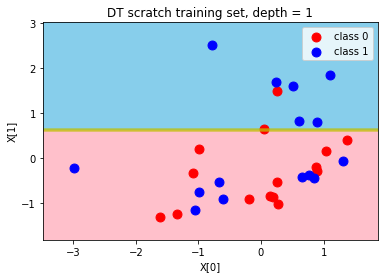

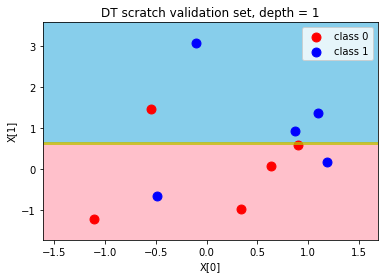

In [369]:
decision_region(
    X_train_std, 
    y_train, 
    dt_scratch, 
    title="DT scratch training set, depth = 1", 
    xlabel="X[0]", 
    ylabel="X[1]",
    target_names=['class 0', 'class 1']
)

decision_region(
    X_test_std, 
    y_test, 
    dt_scratch, 
    title="DT scratch validation set, depth = 1", 
    xlabel="X[0]", 
    ylabel="X[1]",
    target_names=['class 0', 'class 1']
)

<h4>Sklearn training</h4>

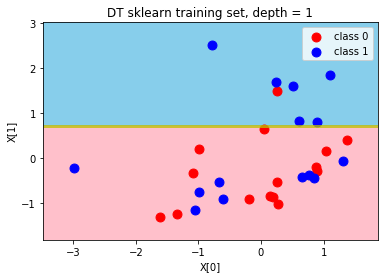

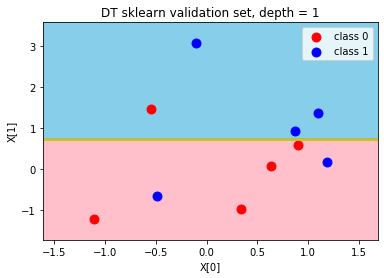

In [370]:
decision_region(
    X_train_std, 
    y_train, 
    dt_sklearn, 
    title="DT sklearn training set, depth = 1", 
    xlabel="X[0]", 
    ylabel="X[1]",
    target_names=['class 0', 'class 1']
)

decision_region(
    X_test_std, 
    y_test, 
    dt_sklearn, 
    title="DT sklearn validation set, depth = 1", 
    xlabel="X[0]", 
    ylabel="X[1]",
    target_names=['class 0', 'class 1']
)